In [ ]:
! nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 使用ReLU替代Sigmoid

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:10.01%
Epoch [1/20], Step [100/938], Loss: 1.7911
Epoch [1/20], Step [200/938], Loss: 0.9796
Epoch [1/20], Step [300/938], Loss: 0.8233
Epoch [1/20], Step [400/938], Loss: 0.8299
Epoch [1/20], Step [500/938], Loss: 0.6307
Epoch [1/20], Step [600/938], Loss: 0.6566
Epoch [1/20], Step [700/938], Loss: 0.7297
Epoch [1/20], Step [800/938], Loss: 0.8026
Epoch [1/20], Step [900/938], Loss: 0.5544
test accuracy:75.22%
Epoch [2/20], Step [100/938], Loss: 0.6690
Epoch [2/20], Step [200/938], Loss: 0.5998
Epoch [2/20], Step [300/938], Loss: 0.4219
Epoch [2/20], Step [400/938], Loss: 0.5054
Epoch [2/20], Step [500/938], Loss: 0.4498
Epoch [2/20], Step [600/938], Loss: 0.6279
Epoch [2/20], Step [700/938], Loss: 0.5761
Epoch [2/20], Step [800/938], Loss: 0.5356
Epoch [2/20], Step [900/938], Loss: 0.5119
test accuracy:77.73%
Epoch [3/20], Step [100/938], Loss: 0.4518
Epoch [3/20], Step [200/938], Loss: 0.6490
Epoch [3/20], S

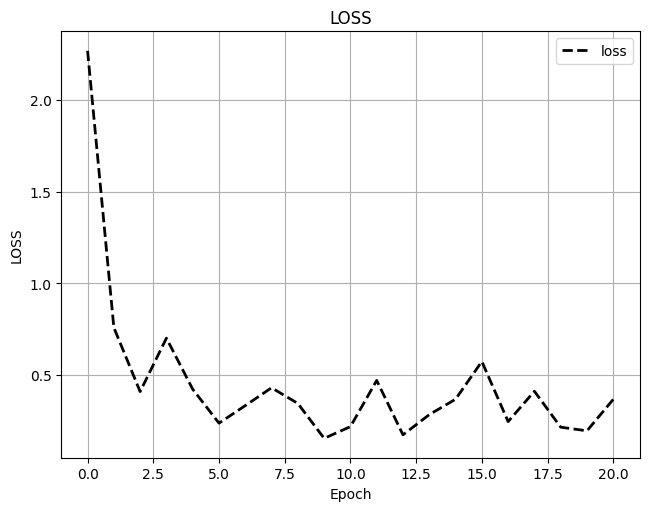

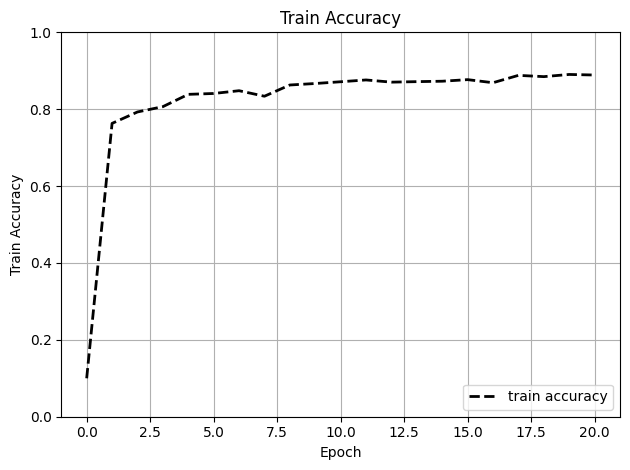

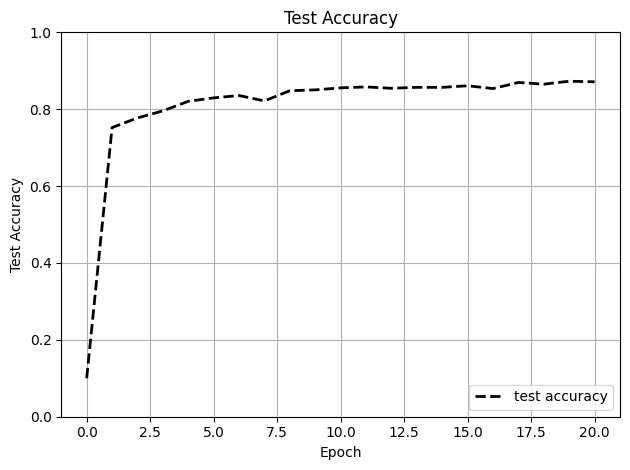

In [4]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5, 5), 1, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, (5, 5))
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)

        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        # 将x展开
        x = x.view(-1, 16 * 5 * 5)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        x = self.linear3(x)
        return x


def main():
    batch_size = 64
    learning_rate = 0.01
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/drive/MyDrive/Data',
                      train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/drive/MyDrive/Data',
                      train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



# 将sigmoid与batch normalization结合使用

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:7.93%
Epoch [1/20], Step [100/235], Loss: 0.5526
Epoch [1/20], Step [200/235], Loss: 0.4497
test accuracy:82.56%
Epoch [2/20], Step [100/235], Loss: 0.4799
Epoch [2/20], Step [200/235], Loss: 0.3920
test accuracy:84.85%
Epoch [3/20], Step [100/235], Loss: 0.4315
Epoch [3/20], Step [200/235], Loss: 0.3566
test accuracy:85.92%
Epoch [4/20], Step [100/235], Loss: 0.3117
Epoch [4/20], Step [200/235], Loss: 0.2953
test accuracy:86.17%
Epoch [5/20], Step [100/235], Loss: 0.3830
Epoch [5/20], Step [200/235], Loss: 0.3350
test accuracy:86.24%
Epoch [6/20], Step [100/235], Loss: 0.2924
Epoch [6/20], Step [200/235], Loss: 0.2789
test accuracy:87.72%
Epoch [7/20], Step [100/235], Loss: 0.2547
Epoch [7/20], Step [200/235], Loss: 0.2009
test accuracy:86.29%
Epoch [8/20], Step [100/235], Loss: 0.2483
Epoch [8/20], Step [200/235], Loss: 0.2465
test accuracy:89.06%
Epoch [9/20], Step [100/235], Loss: 0.2662
Epoch [9/20], Step 

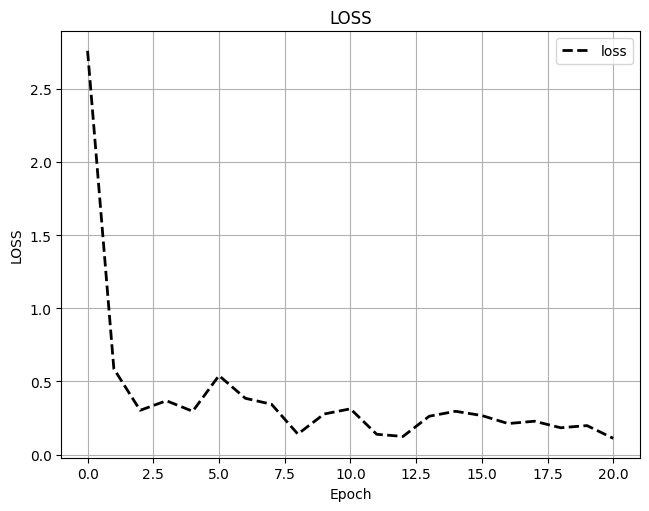

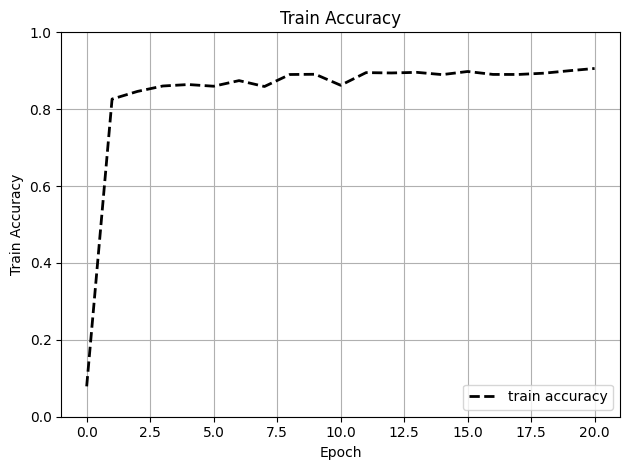

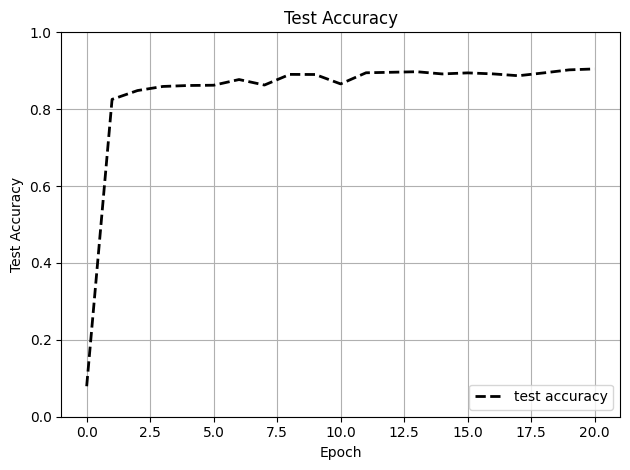

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5, 5), 1, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, (5, 5))
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)
        self.bn1 = torch.nn.BatchNorm2d(6)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.bn3 = torch.nn.BatchNorm1d(120)
        self.bn4 = torch.nn.BatchNorm1d(84)
        self.bn5 = torch.nn.BatchNorm1d(10)


        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        # 将x展开
        x = x.view(-1, 16 * 5 * 5)
        x = self.linear1(x)
        x = self.bn3(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = self.bn4(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        x = self.bn5(x)
        return x


def main():
    batch_size = 64
    learning_rate = 0.9
    num_epoch = 10

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/drive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/drive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



# 调整卷积核大小

将原始的5，5卷积核改为7，7

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:10.00%
Epoch [1/20], Step [100/235], Loss: 2.0417
Epoch [1/20], Step [200/235], Loss: 1.1926
test accuracy:59.33%
Epoch [2/20], Step [100/235], Loss: 0.8269
Epoch [2/20], Step [200/235], Loss: 0.7939
test accuracy:70.42%
Epoch [3/20], Step [100/235], Loss: 0.6355
Epoch [3/20], Step [200/235], Loss: 0.6300
test accuracy:74.66%
Epoch [4/20], Step [100/235], Loss: 0.5187
Epoch [4/20], Step [200/235], Loss: 0.5922
test accuracy:74.13%
Epoch [5/20], Step [100/235], Loss: 0.5191
Epoch [5/20], Step [200/235], Loss: 0.6012
test accuracy:79.10%
Epoch [6/20], Step [100/235], Loss: 0.5581
Epoch [6/20], Step [200/235], Loss: 0.5866
test accuracy:77.06%
Epoch [7/20], Step [100/235], Loss: 0.5485
Epoch [7/20], Step [200/235], Loss: 0.3829
test accuracy:81.20%
Epoch [8/20], Step [100/235], Loss: 0.4436
Epoch [8/20], Step [200/235], Loss: 0.4427
test accuracy:82.20%
Epoch [9/20], Step [100/235], Loss: 0.4258
Epoch [9/20], Step

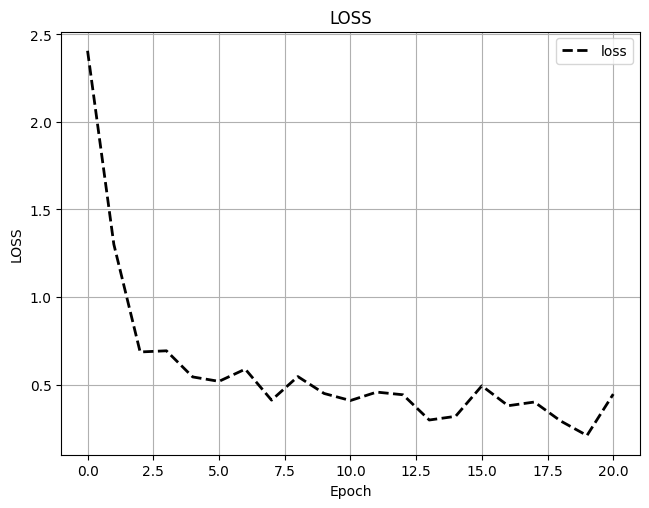

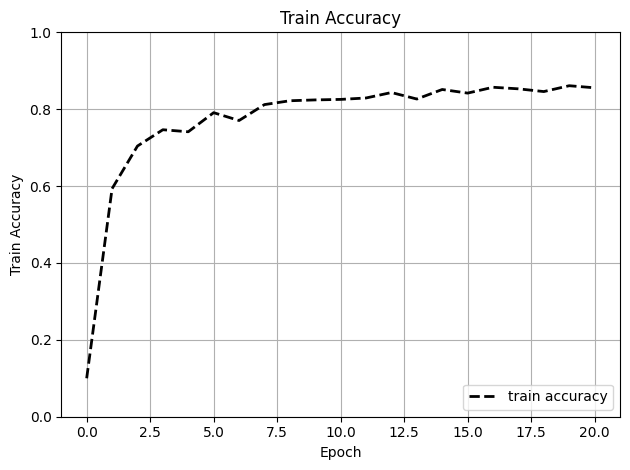

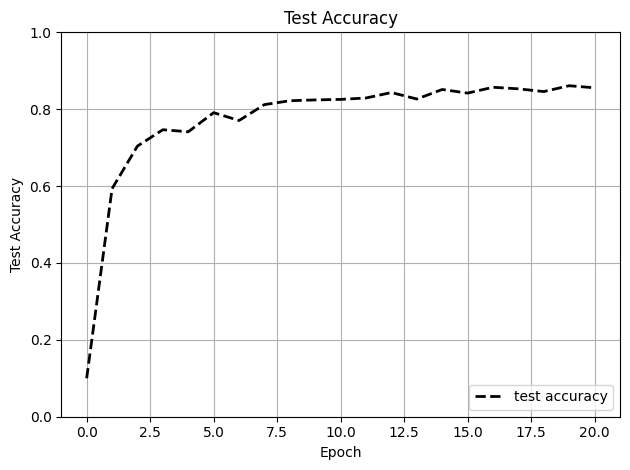

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (7, 7), 1, 3)
        self.conv2 = torch.nn.Conv2d(6, 16, (7, 7))
        self.linear1 = torch.nn.Linear(256, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)


        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.sigmoid(x) # 6 28*28
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 6 14*14
        x = self.conv2(x)         # 16 8*8
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 16 4*4
        # 将x展开
        x = x.view(-1, 16 * 4 * 4)
        x = self.linear1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        return x


def main():
    batch_size = 64
    learning_rate = 0.9
    num_epoch = 10

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



将5，5卷积核改为3，3

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:10.00%
Epoch [1/20], Step [100/235], Loss: 2.3031
Epoch [1/20], Step [200/235], Loss: 1.4279
test accuracy:48.67%
Epoch [2/20], Step [100/235], Loss: 0.8891
Epoch [2/20], Step [200/235], Loss: 1.1639
test accuracy:67.73%
Epoch [3/20], Step [100/235], Loss: 0.6243
Epoch [3/20], Step [200/235], Loss: 0.5885
test accuracy:73.23%
Epoch [4/20], Step [100/235], Loss: 0.7059
Epoch [4/20], Step [200/235], Loss: 0.5364
test accuracy:77.32%
Epoch [5/20], Step [100/235], Loss: 0.7120
Epoch [5/20], Step [200/235], Loss: 0.5330
test accuracy:76.67%
Epoch [6/20], Step [100/235], Loss: 0.6003
Epoch [6/20], Step [200/235], Loss: 0.5575
test accuracy:78.63%
Epoch [7/20], Step [100/235], Loss: 0.4301
Epoch [7/20], Step [200/235], Loss: 0.3837
test accuracy:78.96%
Epoch [8/20], Step [100/235], Loss: 0.5494
Epoch [8/20], Step [200/235], Loss: 0.5178
test accuracy:81.92%
Epoch [9/20], Step [100/235], Loss: 0.4722
Epoch [9/20], Step

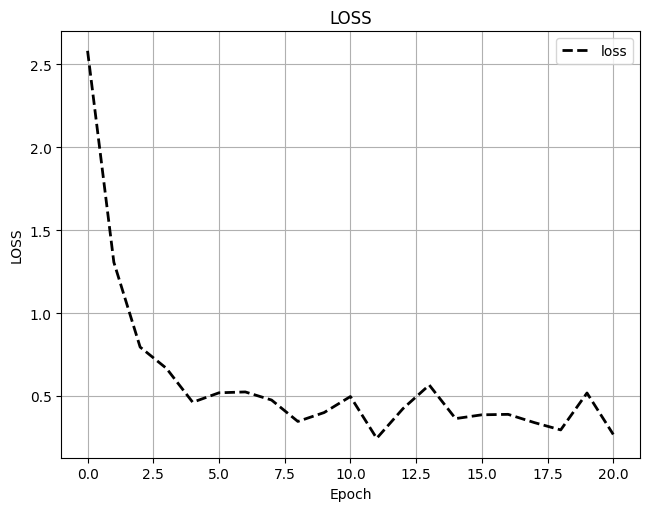

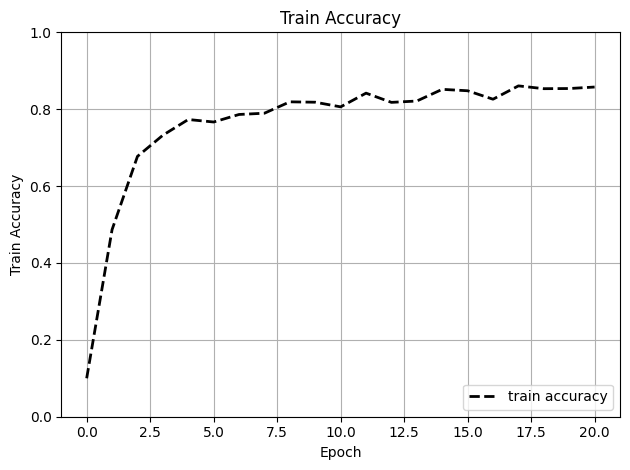

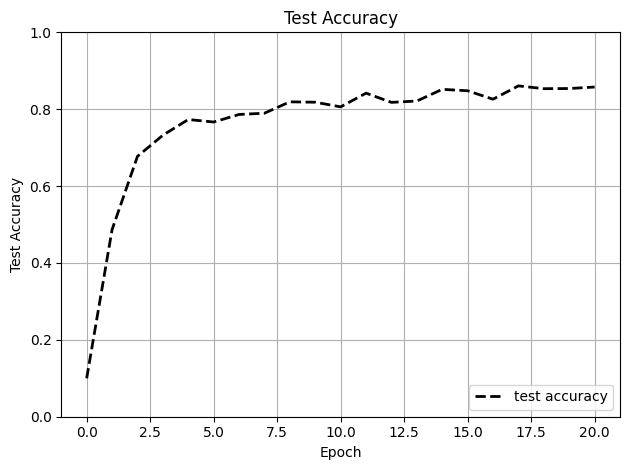

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (3, 3), 1, 1)
        self.conv2 = torch.nn.Conv2d(6, 16, (3, 3))
        self.linear1 = torch.nn.Linear(576, 120) # 6*6*16
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)


        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.sigmoid(x) # 6 28*28
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 6 14*14
        x = self.conv2(x)         # 16 12*12
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 16 6*6
        # 将x展开
        x = x.view(-1, 16 * 6 * 6)
        x = self.linear1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        return x


def main():
    batch_size = 64
    learning_rate = 0.9
    num_epoch = 10

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



# 调整卷积层数

增加conv1类型卷积层数

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:10.00%
Epoch [1/20], Step [100/235], Loss: 2.3009
Epoch [1/20], Step [200/235], Loss: 2.3120
test accuracy:10.00%
Epoch [2/20], Step [100/235], Loss: 2.2802
Epoch [2/20], Step [200/235], Loss: 1.2173
test accuracy:53.64%
Epoch [3/20], Step [100/235], Loss: 1.0785
Epoch [3/20], Step [200/235], Loss: 0.7776
test accuracy:73.17%
Epoch [4/20], Step [100/235], Loss: 0.7084
Epoch [4/20], Step [200/235], Loss: 0.6871
test accuracy:73.05%
Epoch [5/20], Step [100/235], Loss: 0.5907
Epoch [5/20], Step [200/235], Loss: 0.5989
test accuracy:72.42%
Epoch [6/20], Step [100/235], Loss: 0.5474
Epoch [6/20], Step [200/235], Loss: 0.4975
test accuracy:76.07%
Epoch [7/20], Step [100/235], Loss: 0.5183
Epoch [7/20], Step [200/235], Loss: 0.9476
test accuracy:77.34%
Epoch [8/20], Step [100/235], Loss: 0.5496
Epoch [8/20], Step [200/235], Loss: 0.4268
test accuracy:73.11%
Epoch [9/20], Step [100/235], Loss: 0.4365
Epoch [9/20], Step

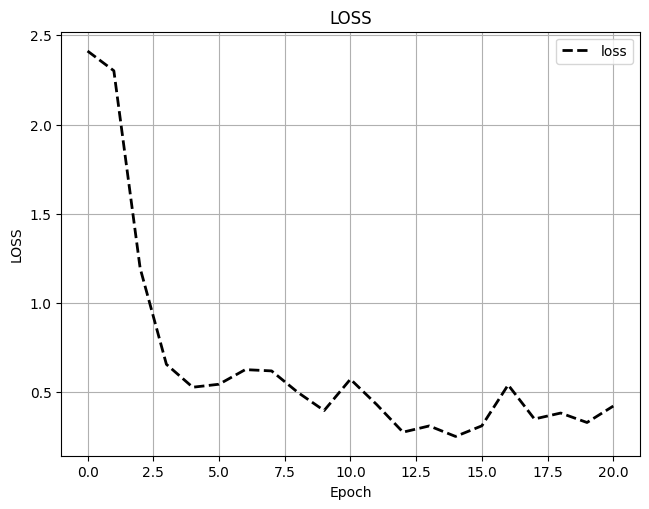

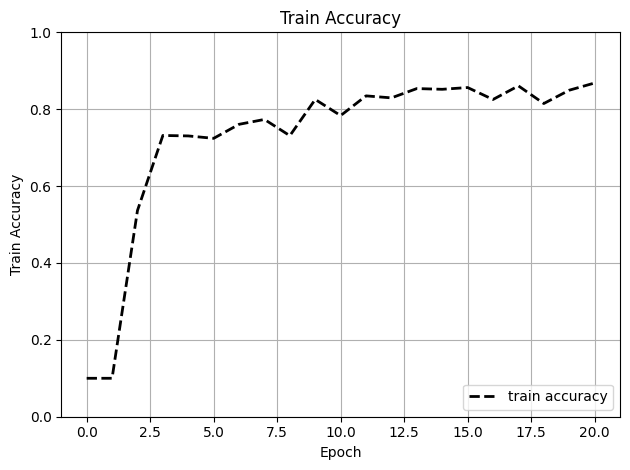

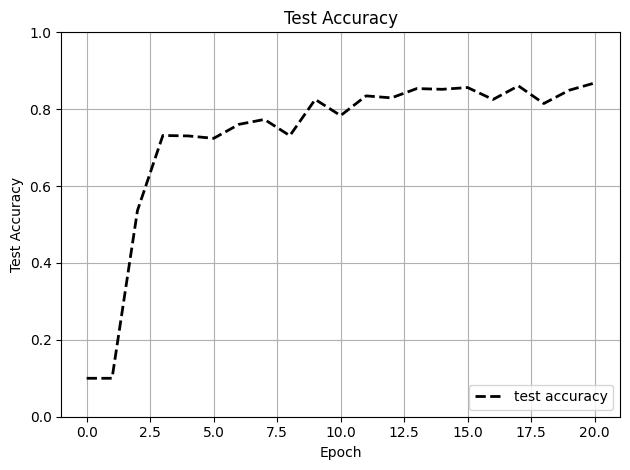

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5, 5), 1, 2)
        self.conv2 = torch.nn.Conv2d(6, 6, (5, 5), 1, 2)
        self.conv3 = torch.nn.Conv2d(6, 16, (5, 5))
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)


        # 如果没有参数初始化，基本上很难训练成功，应该是梯度消失/爆炸？？
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.sigmoid(x)  # 6 28*28
        x = self.conv2(x)
        x = torch.nn.functional.sigmoid(x) # 6 28*28
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 6 14*14
        x = self.conv3(x)         # 16 10*10
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 16 5*5
        # 将x展开
        x = x.view(-1, 16 * 5 * 5)
        x = self.linear1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        return x


def main():
    batch_size = 64
    learning_rate = 0.9
    num_epoch = 10

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



因为当前流行小卷积+核深度网络+多通道

故调整卷积核大小，多使用3*3卷积，增加通道数量

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:16.86%
Epoch [1/20], Step [100/235], Loss: 0.6716
Epoch [1/20], Step [200/235], Loss: 0.5546
test accuracy:75.70%
Epoch [2/20], Step [100/235], Loss: 0.5117
Epoch [2/20], Step [200/235], Loss: 0.5291
test accuracy:78.14%
Epoch [3/20], Step [100/235], Loss: 0.5107
Epoch [3/20], Step [200/235], Loss: 0.5180
test accuracy:79.38%
Epoch [4/20], Step [100/235], Loss: 0.4912
Epoch [4/20], Step [200/235], Loss: 0.4917
test accuracy:80.51%
Epoch [5/20], Step [100/235], Loss: 0.4435
Epoch [5/20], Step [200/235], Loss: 0.4902
test accuracy:81.54%
Epoch [6/20], Step [100/235], Loss: 0.5118
Epoch [6/20], Step [200/235], Loss: 0.4511
test accuracy:81.27%
Epoch [7/20], Step [100/235], Loss: 0.4516
Epoch [7/20], Step [200/235], Loss: 0.3548
test accuracy:80.10%
Epoch [8/20], Step [100/235], Loss: 0.4060
Epoch [8/20], Step [200/235], Loss: 0.4407
test accuracy:82.43%
Epoch [9/20], Step [100/235], Loss: 0.3762
Epoch [9/20], Step

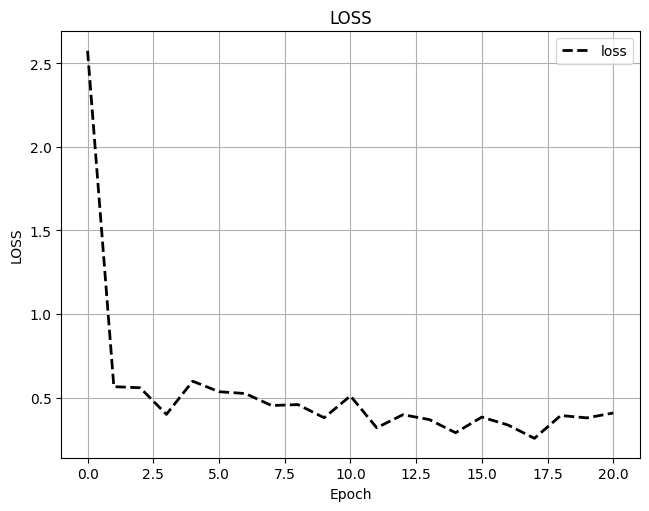

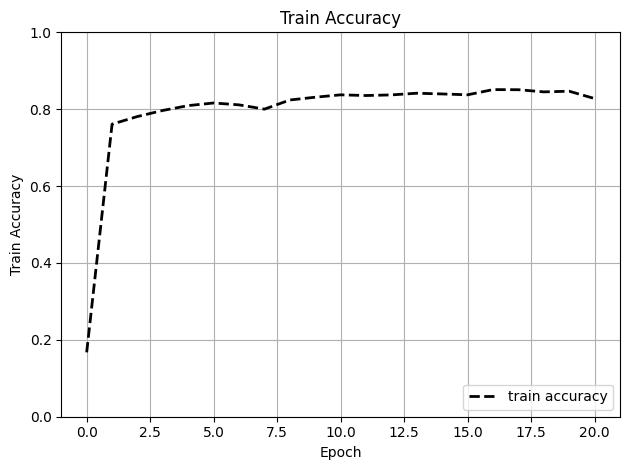

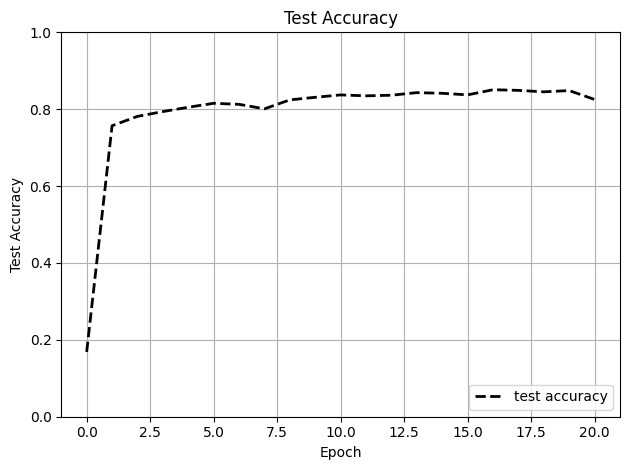

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, (3, 3), 1, 0)
        self.conv2 = torch.nn.Conv2d(4, 8, (3, 3), 1, 0)
        self.conv3 = torch.nn.Conv2d(8, 16, (1, 1), 1, 0)
        self.conv4 = torch.nn.Conv2d(16, 32, (1, 1), 1, 0)
        self.linear1 = torch.nn.Linear(128, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)

        self.bn1 = torch.nn.BatchNorm2d(4)
        self.bn2 = torch.nn.BatchNorm2d(8)
        self.bn3 = torch.nn.BatchNorm2d(16)
        self.bn4 = torch.nn.BatchNorm2d(32)
        self.bn5 = torch.nn.BatchNorm1d(120)
        self.bn6 = torch.nn.BatchNorm1d(84)
        self.bn7 = torch.nn.BatchNorm1d(10)

        # 如果没有参数初始化，基本上很难训练成功，应该是梯度消失/爆炸？？
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.sigmoid(x)  # 4 26*26
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 4 13*13
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.functional.sigmoid(x) # 8 9*9
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 8 4*4
        x = self.conv3(x)         # 16 4*4
        x = self.bn3(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2) # 16 2*2
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.nn.functional.sigmoid(x) # 32 2*2

        # 将x展开
        x = x.view(-1, 32 * 2 * 2)
        x = self.linear1(x)
        x = self.bn5(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = self.bn6(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        x = self.bn7(x)
        return x


def main():
    batch_size = 256
    learning_rate = 0.9
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, test_labels in test_loader:
                        train_images = train_images.float()
                        test_labels = test_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += test_labels.size(0)
                        correct += (predicted == test_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, test_labels in test_loader:
                train_images = train_images.float()
                test_labels = test_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_labels.size(0)
                correct += (predicted == test_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



# 使用max polling

在原网络的基础上

将average polling替换为max polling

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:12.51%
Epoch [1/20], Step [100/235], Loss: 0.5482
Epoch [1/20], Step [200/235], Loss: 0.4358
test accuracy:83.81%
Epoch [2/20], Step [100/235], Loss: 0.3255
Epoch [2/20], Step [200/235], Loss: 0.2760
test accuracy:86.33%
Epoch [3/20], Step [100/235], Loss: 0.3265
Epoch [3/20], Step [200/235], Loss: 0.3294
test accuracy:87.09%
Epoch [4/20], Step [100/235], Loss: 0.3464
Epoch [4/20], Step [200/235], Loss: 0.4042
test accuracy:87.37%
Epoch [5/20], Step [100/235], Loss: 0.3311
Epoch [5/20], Step [200/235], Loss: 0.3211
test accuracy:88.21%
Epoch [6/20], Step [100/235], Loss: 0.3798
Epoch [6/20], Step [200/235], Loss: 0.3306
test accuracy:88.52%
Epoch [7/20], Step [100/235], Loss: 0.2263
Epoch [7/20], Step [200/235], Loss: 0.2239
test accuracy:88.10%
Epoch [8/20], Step [100/235], Loss: 0.2668
Epoch [8/20], Step [200/235], Loss: 0.2918
test accuracy:88.81%
Epoch [9/20], Step [100/235], Loss: 0.2382
Epoch [9/20], Step

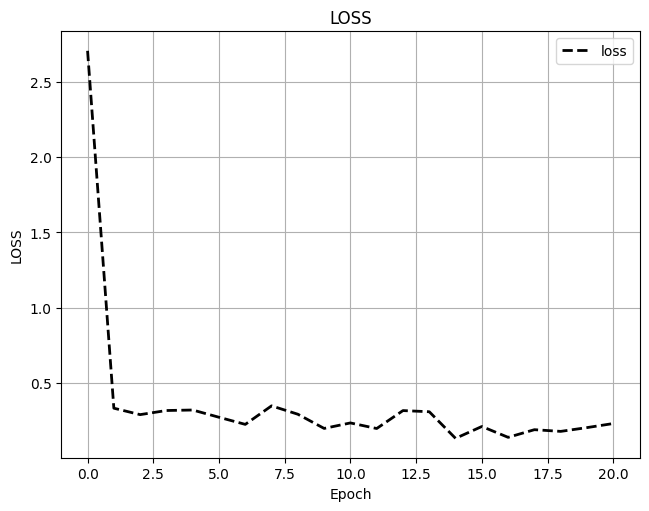

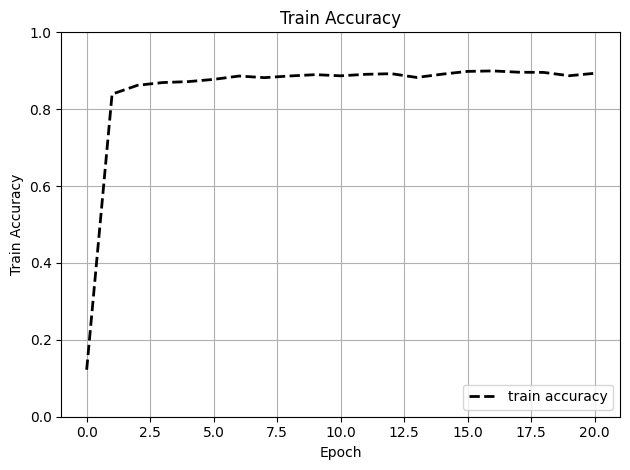

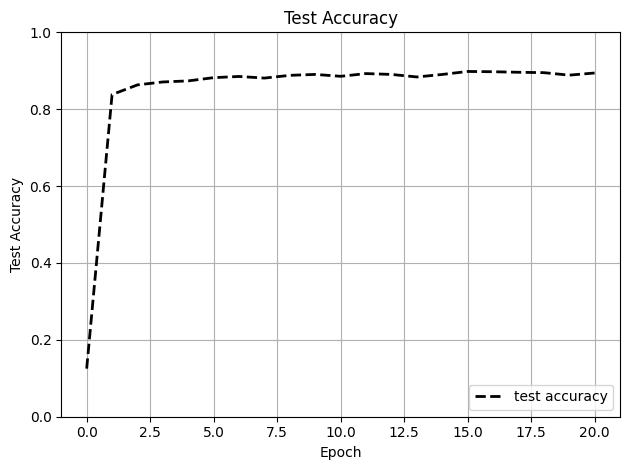

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5, 5), 1, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, (5, 5))
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)
        self.bn1 = torch.nn.BatchNorm2d(6)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.bn3 = torch.nn.BatchNorm1d(120)
        self.bn4 = torch.nn.BatchNorm1d(84)
        self.bn5 = torch.nn.BatchNorm1d(10)


        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2), 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.max_pool2d(x, (2, 2), 2)
        # 将x展开
        x = x.view(-1, 16 * 5 * 5)
        x = self.linear1(x)
        x = self.bn3(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = self.bn4(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        x = self.bn5(x)
        return x


def main():
    batch_size = 64
    learning_rate = 0.9
    num_epoch = 10

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



# 尝试不同的优化器及学习率

## 使用SDG+momentum

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:10.00%
Epoch [1/10], Step [100/1875], Loss: 2.3289
Epoch [1/10], Step [200/1875], Loss: 2.3113
Epoch [1/10], Step [300/1875], Loss: 2.3335
Epoch [1/10], Step [400/1875], Loss: 2.2738
Epoch [1/10], Step [500/1875], Loss: 2.3099
Epoch [1/10], Step [600/1875], Loss: 2.2967
Epoch [1/10], Step [700/1875], Loss: 2.2926
Epoch [1/10], Step [800/1875], Loss: 2.3244
Epoch [1/10], Step [900/1875], Loss: 2.2731
Epoch [1/10], Step [1000/1875], Loss: 2.1140
Epoch [1/10], Step [1100/1875], Loss: 2.0232
Epoch [1/10], Step [1200/1875], Loss: 1.6515
Epoch [1/10], Step [1300/1875], Loss: 1.3060
Epoch [1/10], Step [1400/1875], Loss: 1.4148
Epoch [1/10], Step [1500/1875], Loss: 1.2881
Epoch [1/10], Step [1600/1875], Loss: 1.0023
Epoch [1/10], Step [1700/1875], Loss: 1.3104
Epoch [1/10], Step [1800/1875], Loss: 1.1201
test accuracy:62.94%
Epoch [2/10], Step [100/1875], Loss: 1.0661
Epoch [2/10], Step [200/1875], Loss: 1.2129
Epoch [

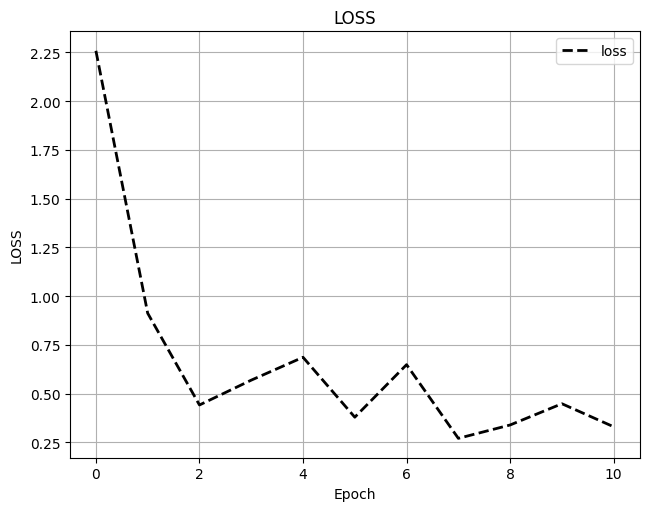

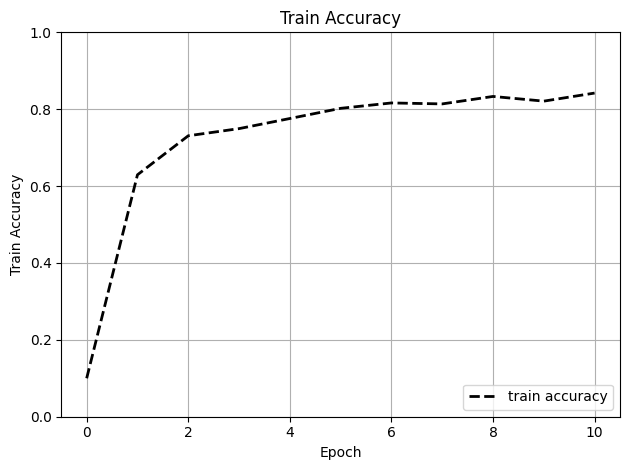

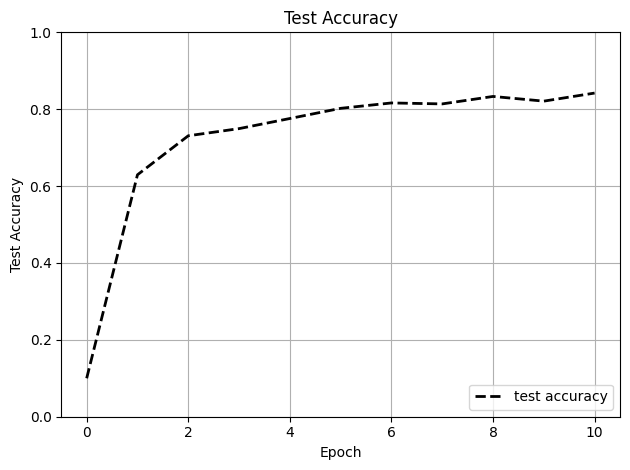

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5, 5), 1, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, (5, 5))
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)

        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        x = self.conv2(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        # 将x展开
        x = x.view(-1, 16 * 5 * 5)
        x = self.linear1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        return x


def main():
    batch_size = 32
    learning_rate = 0.01
    num_epoch = 10

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



## 使用Adam

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:10.00%
Epoch [1/10], Step [100/1875], Loss: 2.2127
Epoch [1/10], Step [200/1875], Loss: 1.5531
Epoch [1/10], Step [300/1875], Loss: 1.1246
Epoch [1/10], Step [400/1875], Loss: 1.0042
Epoch [1/10], Step [500/1875], Loss: 0.8808
Epoch [1/10], Step [600/1875], Loss: 0.6904
Epoch [1/10], Step [700/1875], Loss: 0.8428
Epoch [1/10], Step [800/1875], Loss: 0.8340
Epoch [1/10], Step [900/1875], Loss: 0.5863
Epoch [1/10], Step [1000/1875], Loss: 0.8867
Epoch [1/10], Step [1100/1875], Loss: 0.6263
Epoch [1/10], Step [1200/1875], Loss: 0.5706
Epoch [1/10], Step [1300/1875], Loss: 0.5455
Epoch [1/10], Step [1400/1875], Loss: 0.7907
Epoch [1/10], Step [1500/1875], Loss: 0.6948
Epoch [1/10], Step [1600/1875], Loss: 0.6460
Epoch [1/10], Step [1700/1875], Loss: 0.5244
Epoch [1/10], Step [1800/1875], Loss: 0.5753
test accuracy:75.46%
Epoch [2/10], Step [100/1875], Loss: 0.4963
Epoch [2/10], Step [200/1875], Loss: 0.6217
Epoch [

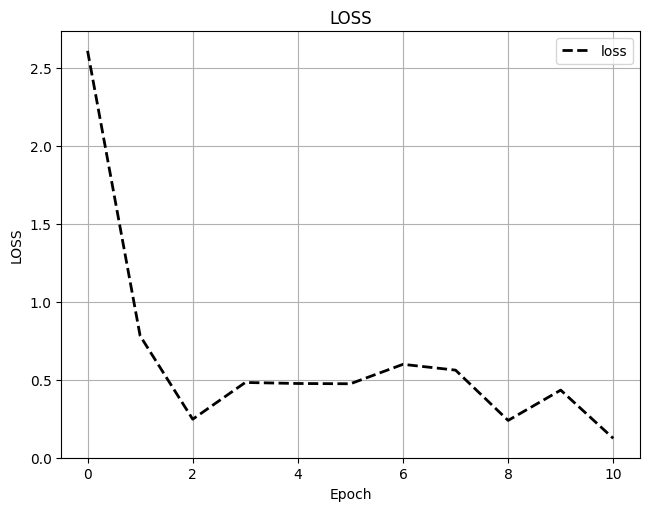

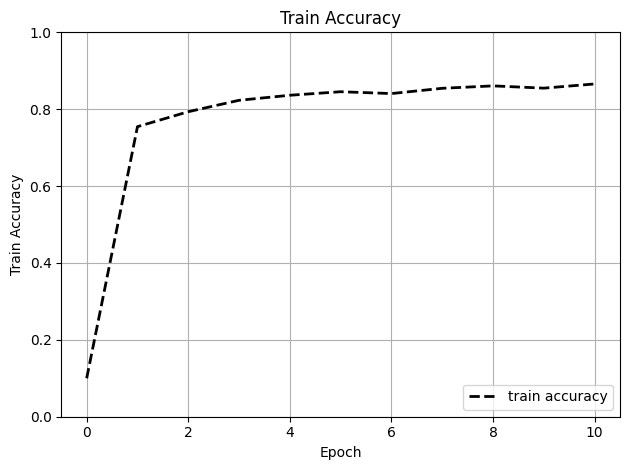

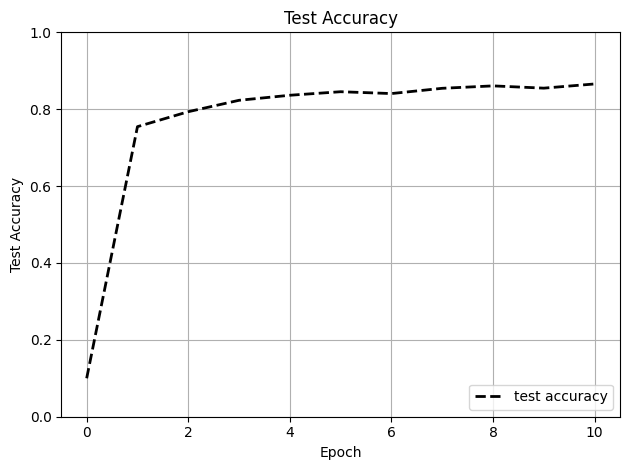

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5, 5), 1, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, (5, 5))
        self.linear1 = torch.nn.Linear(400, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)

        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        x = self.conv2(x)
        x = torch.nn.functional.sigmoid(x)
        x = torch.nn.functional.avg_pool2d(x, (2, 2), 2)
        # 将x展开
        x = x.view(-1, 16 * 5 * 5)
        x = self.linear1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear2(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.linear3(x)
        return x


def main():
    batch_size = 32
    learning_rate = 0.001
    num_epoch = 10

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()



# 使用现代卷积神经网络结构

## 使用VGG块

using cuda:0 device.
Using 2 dataloader workers every process


100%|██████████| 26421880/26421880 [00:01<00:00, 17124564.57it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 276926.22it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5099799.72it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25522786.04it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw

test accuracy:10.00%
Epoch [1/20], Step [100/1875], Loss: 0.7752
Epoch [1/20], Step [200/1875], Loss: 0.5229
Epoch [1/20], Step [300/1875], Loss: 0.4598
Epoch [1/20], Step [400/1875], Loss: 0.5495
Epoch [1/20], Step [500/1875], Loss: 0.7893
Epoch [1/20], Step [600/1875], Loss: 0.4822
Epoch [1/20], Step [700/1875], Loss: 0.5760
Epoch [1/20], Step [800/1875], Loss: 0.8045
Epoch [1/20], Step [900/1875], Loss: 0.4840
Epoch [1/20], Step [1000/1875], Loss: 0.3788
Epoch [1/20], Step [1100/1875], Loss: 0.2960
Epoch [1/20], Step [1200/1875], Loss: 0.2433
Epoch [1/20], Step [1300/1875], Loss: 0.2987
Epoch [1/20], Step [1400/1875], Loss: 0.1575
Epoch [1/20], Step [1500/1875], Loss: 0.2436
Epoch [1/20], Step [1600/1875], Loss: 0.4248
Epoch [1/20], Step [1700/1875], Loss: 0.2664
Epoch [1/20], Step [1800/1875], Loss: 0.1404
test accuracy:86.92%
Epoch [2/20], Step [100/

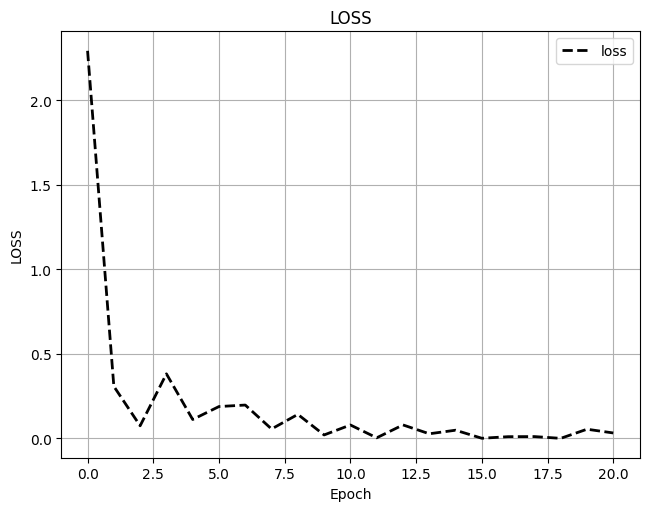

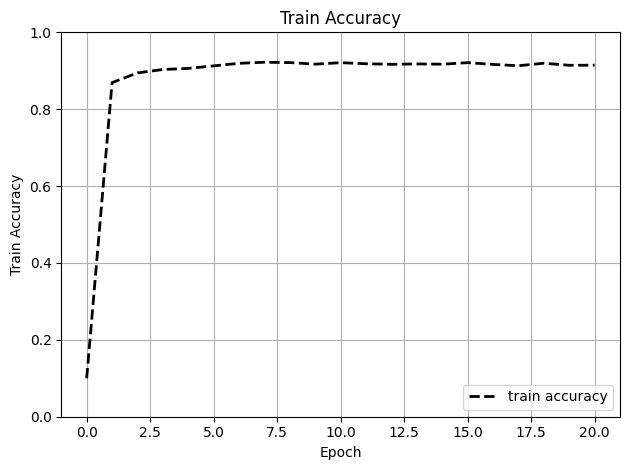

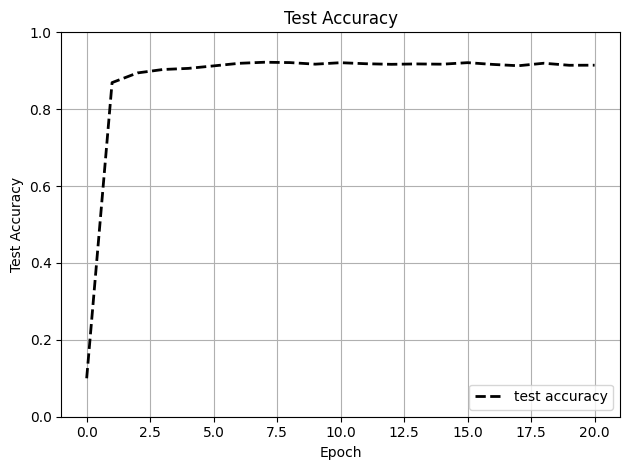

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = VGG(16, 16, 16) # ch3*14*14
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*14*14, 120),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16*14*14) # 将x展开
        x = self.classifier(x)
        return x


class VGG(torch.nn.Module):
    def __init__(self, ch1, ch2, ch3):
        super(VGG, self).__init__()  # 1*28*28
        self.vgg = torch.nn.Sequential(
            torch.nn.Conv2d(1, ch1, 3, 1, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch1, ch2, 3, 1, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch2, ch3, 3, 1, 1),
            torch.nn.ReLU(inplace=True),  # ch3*28*28
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # ch3*14*14
        )

    def forward(self, x):
        x = self.vgg(x)
        return x


def main():
    batch_size = 32
    learning_rate = 0.0004
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()





## 使用NiN块

using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:17.71%
Epoch [1/20], Step [100/1875], Loss: 0.8106
Epoch [1/20], Step [200/1875], Loss: 0.8055
Epoch [1/20], Step [300/1875], Loss: 1.1032
Epoch [1/20], Step [400/1875], Loss: 0.6308
Epoch [1/20], Step [500/1875], Loss: 0.6218
Epoch [1/20], Step [600/1875], Loss: 0.5161
Epoch [1/20], Step [700/1875], Loss: 0.6984
Epoch [1/20], Step [800/1875], Loss: 0.4879
Epoch [1/20], Step [900/1875], Loss: 0.6535
Epoch [1/20], Step [1000/1875], Loss: 0.5585
Epoch [1/20], Step [1100/1875], Loss: 0.3521
Epoch [1/20], Step [1200/1875], Loss: 0.4420
Epoch [1/20], Step [1300/1875], Loss: 0.9290
Epoch [1/20], Step [1400/1875], Loss: 0.3217
Epoch [1/20], Step [1500/1875], Loss: 0.6295
Epoch [1/20], Step [1600/1875], Loss: 0.6476
Epoch [1/20], Step [1700/1875], Loss: 0.7929
Epoch [1/20], Step [1800/1875], Loss: 0.7793
test accuracy:81.05%
Epoch [2/20], Step [100/1875], Loss: 0.5952
Epoch [2/20], Step [200/1875], Loss: 0.6203
Epoch [

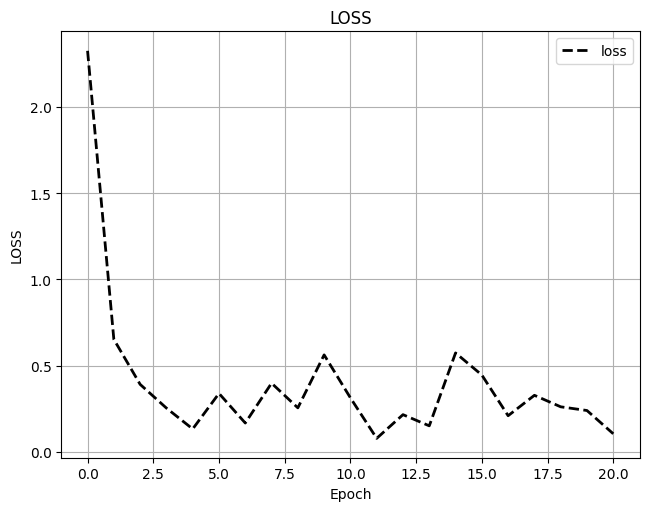

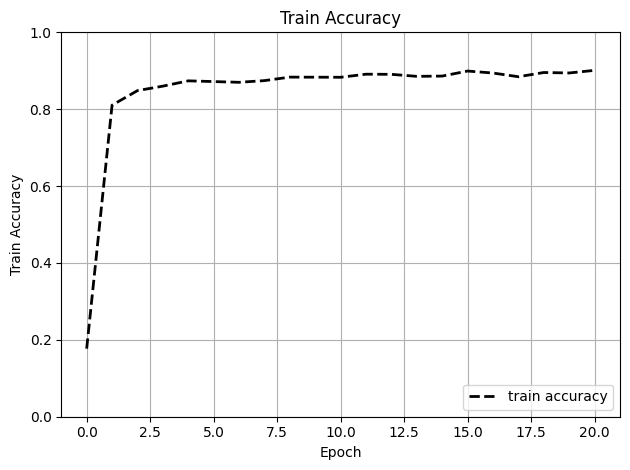

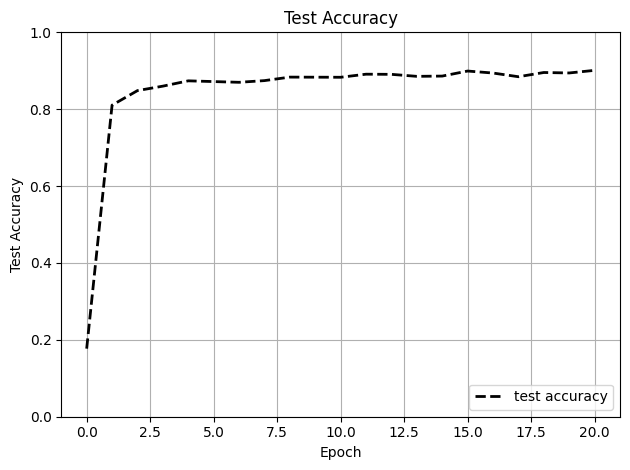

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = NiN(64)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        return x


class VGG(torch.nn.Module):
    def __init__(self, ch1, ch2, ch3):
        super(VGG, self).__init__()  # 1*28*28
        self.vgg = torch.nn.Sequential(
            torch.nn.Conv2d(1, ch1, 3, 1, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch1, ch2, 3, 1, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch2, ch3, 3, 1, 1),
            torch.nn.ReLU(inplace=True),  # ch3*28*28
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # ch3*14*14
        )

    def forward(self, x):
        x = self.vgg(x)
        return x


class NiN(torch.nn.Module):
    def __init__(self,ch):
        super(NiN, self).__init__()
        self.nin = torch.nn.Sequential(
            torch.nn.Conv2d(1,ch,11,1,2), # 32*22*22
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch,ch,5),# 32*18*18
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch,ch,3),# 32*16*16
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch,ch,1),# 32*16*16
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch,ch,1),# 32*16*16
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d((3, 3), 2),# 32*6*6

            # 因为是分为10类，所以将通道数置为10
            torch.nn.Conv2d(ch, 10, 1), # 10*6*6
            torch.nn.Conv2d(10, 10, 1), # 10*6*6
            torch.nn.AdaptiveAvgPool2d((1, 1)), # 10*1*1

            torch.nn.Flatten() # batch,10

        )

    def forward(self,x):
        x = self.nin(x)
        return x



def main():
    batch_size = 32
    learning_rate = 0.00025
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()





## 使用Inception块

using cuda:0 device.
Using 2 dataloader workers every process


100%|██████████| 26421880/26421880 [00:01<00:00, 17957914.48it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 276274.21it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5072389.92it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21231344.14it/s]


Extracting /content/gdrive/MyDrive/Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Data/FashionMNIST/raw

test accuracy:10.04%
Epoch [1/20], Step [100/1875], Loss: 2.2620
Epoch [1/20], Step [200/1875], Loss: 2.1751
Epoch [1/20], Step [300/1875], Loss: 2.0621
Epoch [1/20], Step [400/1875], Loss: 1.8653
Epoch [1/20], Step [500/1875], Loss: 1.5507
Epoch [1/20], Step [600/1875], Loss: 1.5775
Epoch [1/20], Step [700/1875], Loss: 1.4550
Epoch [1/20], Step [800/1875], Loss: 1.4276
Epoch [1/20], Step [900/1875], Loss: 1.0567
Epoch [1/20], Step [1000/1875], Loss: 1.1899
Epoch [1/20], Step [1100/1875], Loss: 1.2212
Epoch [1/20], Step [1200/1875], Loss: 1.2449
Epoch [1/20], Step [1300/1875], Loss: 1.2023
Epoch [1/20], Step [1400/1875], Loss: 0.8738
Epoch [1/20], Step [1500/1875], Loss: 1.1284
Epoch [1/20], Step [1600/1875], Loss: 1.3475
Epoch [1/20], Step [1700/1875], Loss: 1.0811
Epoch [1/20], Step [1800/1875], Loss: 0.9953
test accuracy:61.92%
Epoch [2/20], Step [100/

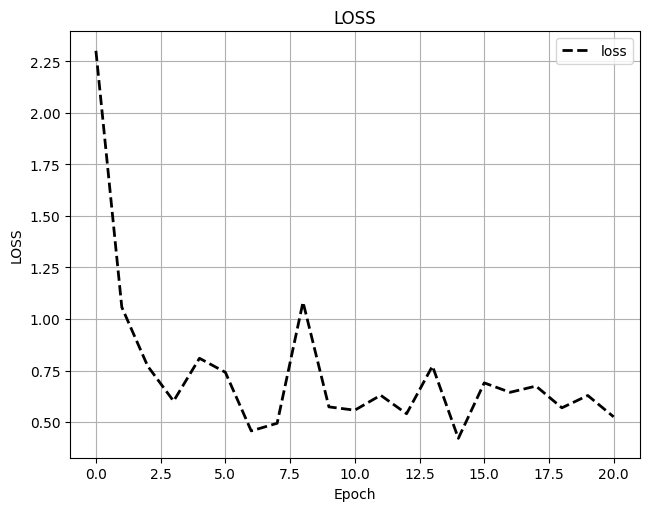

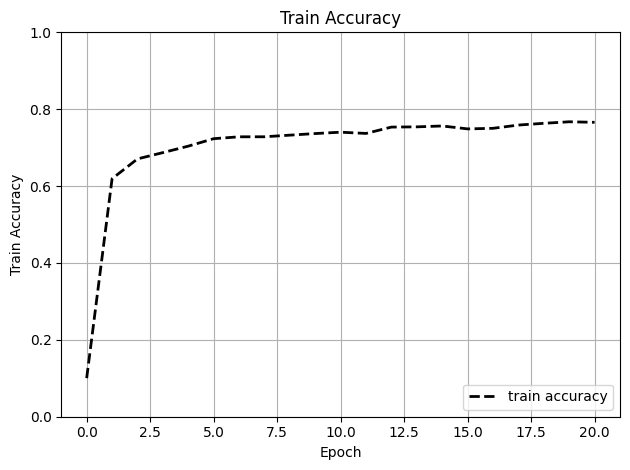

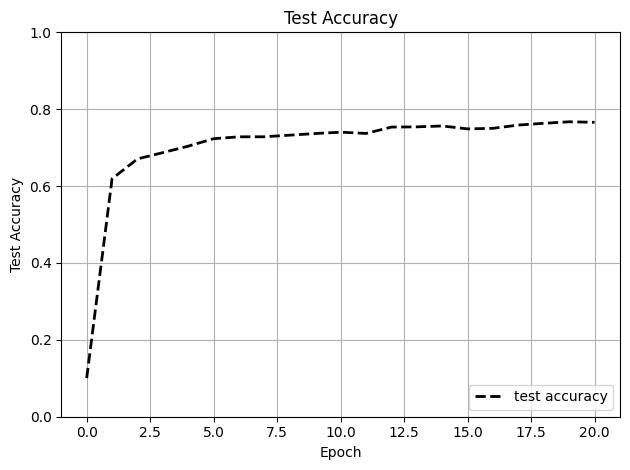

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os




class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(1,4,7,2) # 4 11*11
        self.Relu = torch.nn.ReLU(inplace=True)

        self.features1 = Inception(4,1,1,1,1,1,1) # 4
        self.features2 = Inception(4,4,4,4,4,4,4) # 4*4
        self.features3 = Inception(16,4,4,4,4,4,4) # 4*4 11*11

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16,10)
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Relu(x)
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x,(1,1))
        x = torch.flatten(x, start_dim=1)  # 对张量扁平化处理，即将X展开
        x = self.classifier(x)
        return x


class Inception(torch.nn.Module):
    def __init__(self,inchannels,ch1x1,ch3x3r,ch3x3,ch5x5r,ch5x5,pool_proj):
        super(Inception, self).__init__()
        self.batch1 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels,ch1x1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch2 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch3x3r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch3x3r,ch3x3,3,1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch3 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch5x5r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch5x5r,ch5x5,5,1,2),
            torch.nn.ReLU(inplace=True)
        )
        self.batch4 = torch.nn.Sequential(
            torch.nn.MaxPool2d(3, 1, 1),
            torch.nn.Conv2d(inchannels,pool_proj,1),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self,x):
        b1 = self.batch1(x)
        b2 = self.batch2(x)
        b3 = self.batch3(x)
        b4 = self.batch4(x)

        output = [b1,b2,b3,b4] # batch (ch1x1+ch3x3+ch5x5+pool_proj)

        return torch.cat(output, 1)


def main():
    batch_size = 32
    learning_rate = 0.00025
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()






using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:8.81%
Epoch [1/20], Step [100/1875], Loss: 2.1013
Epoch [1/20], Step [200/1875], Loss: 1.3336
Epoch [1/20], Step [300/1875], Loss: 1.1950
Epoch [1/20], Step [400/1875], Loss: 0.8465
Epoch [1/20], Step [500/1875], Loss: 1.1623
Epoch [1/20], Step [600/1875], Loss: 0.7892
Epoch [1/20], Step [700/1875], Loss: 0.8913
Epoch [1/20], Step [800/1875], Loss: 0.8502
Epoch [1/20], Step [900/1875], Loss: 0.7711
Epoch [1/20], Step [1000/1875], Loss: 0.8291
Epoch [1/20], Step [1100/1875], Loss: 1.1222
Epoch [1/20], Step [1200/1875], Loss: 0.8078
Epoch [1/20], Step [1300/1875], Loss: 0.7906
Epoch [1/20], Step [1400/1875], Loss: 0.6781
Epoch [1/20], Step [1500/1875], Loss: 1.1837
Epoch [1/20], Step [1600/1875], Loss: 0.6411
Epoch [1/20], Step [1700/1875], Loss: 0.7133
Epoch [1/20], Step [1800/1875], Loss: 1.0251
test accuracy:68.97%
Epoch [2/20], Step [100/1875], Loss: 0.7153
Epoch [2/20], Step [200/1875], Loss: 1.1066
Epoch [2

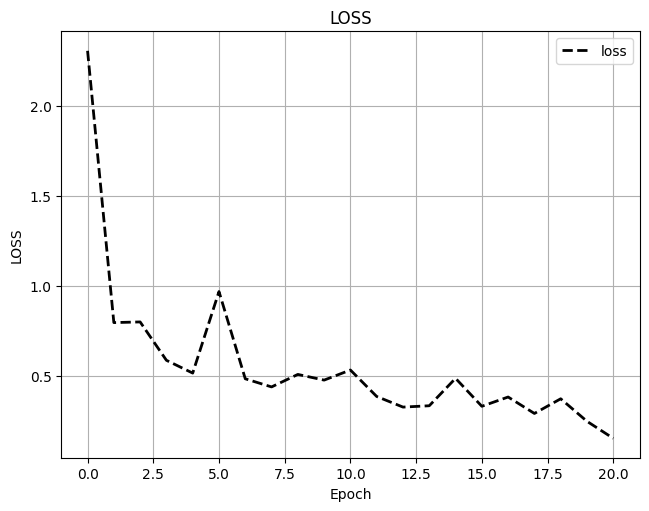

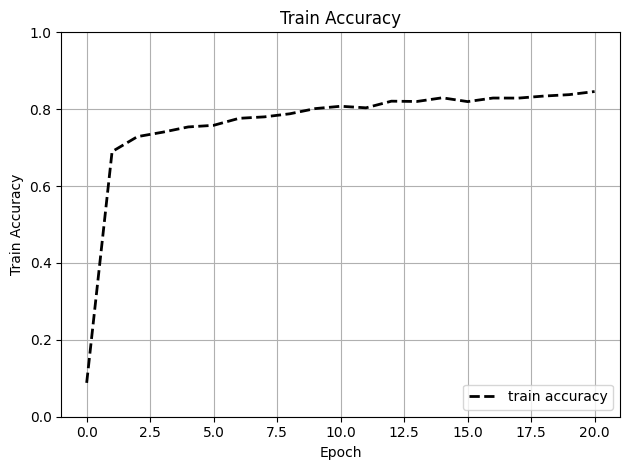

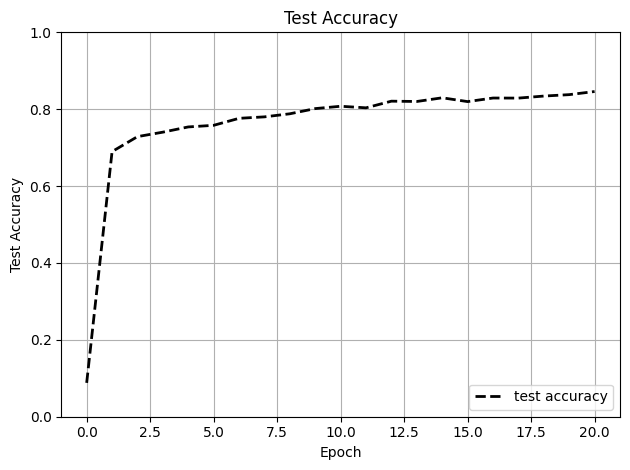

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os



class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(1,4,7,2) # 4 11*11
        self.Relu = torch.nn.ReLU(inplace=True)

        self.features1 = Inception(4,4,4,4,4,4,4) # 16
        self.features2 = Inception(16,8,8,8,8,8,8) # 32
        self.features3 = Inception(32,16,16,16,16,16,16) # 64 11*11

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(64,10)
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Relu(x)
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x,(1,1))
        x = torch.flatten(x, start_dim=1)  # 对张量扁平化处理，即将X展开
        x = self.classifier(x)
        return x


class Inception(torch.nn.Module):
    def __init__(self,inchannels,ch1x1,ch3x3r,ch3x3,ch5x5r,ch5x5,pool_proj):
        super(Inception, self).__init__()
        self.batch1 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels,ch1x1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch2 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch3x3r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch3x3r,ch3x3,3,1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch3 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch5x5r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch5x5r,ch5x5,5,1,2),
            torch.nn.ReLU(inplace=True)
        )
        self.batch4 = torch.nn.Sequential(
            torch.nn.MaxPool2d(3, 1, 1),
            torch.nn.Conv2d(inchannels,pool_proj,1),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self,x):
        b1 = self.batch1(x)
        b2 = self.batch2(x)
        b3 = self.batch3(x)
        b4 = self.batch4(x)

        output = [b1,b2,b3,b4] # batch (ch1x1+ch3x3+ch5x5+pool_proj)

        return torch.cat(output, 1)



def main():
    batch_size = 32
    learning_rate = 0.00025
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()


using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:9.99%
Epoch [1/20], Step [100/938], Loss: 1.2445
Epoch [1/20], Step [200/938], Loss: 1.0350
Epoch [1/20], Step [300/938], Loss: 0.6674
Epoch [1/20], Step [400/938], Loss: 0.8644
Epoch [1/20], Step [500/938], Loss: 0.6750
Epoch [1/20], Step [600/938], Loss: 0.8675
Epoch [1/20], Step [700/938], Loss: 0.7259
Epoch [1/20], Step [800/938], Loss: 0.4716
Epoch [1/20], Step [900/938], Loss: 0.9087
test accuracy:74.04%
Epoch [2/20], Step [100/938], Loss: 0.5964
Epoch [2/20], Step [200/938], Loss: 0.6463
Epoch [2/20], Step [300/938], Loss: 0.5659
Epoch [2/20], Step [400/938], Loss: 0.7355
Epoch [2/20], Step [500/938], Loss: 0.5789
Epoch [2/20], Step [600/938], Loss: 0.5721
Epoch [2/20], Step [700/938], Loss: 0.5728
Epoch [2/20], Step [800/938], Loss: 0.6729
Epoch [2/20], Step [900/938], Loss: 0.7960
test accuracy:78.29%
Epoch [3/20], Step [100/938], Loss: 0.5277
Epoch [3/20], Step [200/938], Loss: 0.5487
Epoch [3/20], St

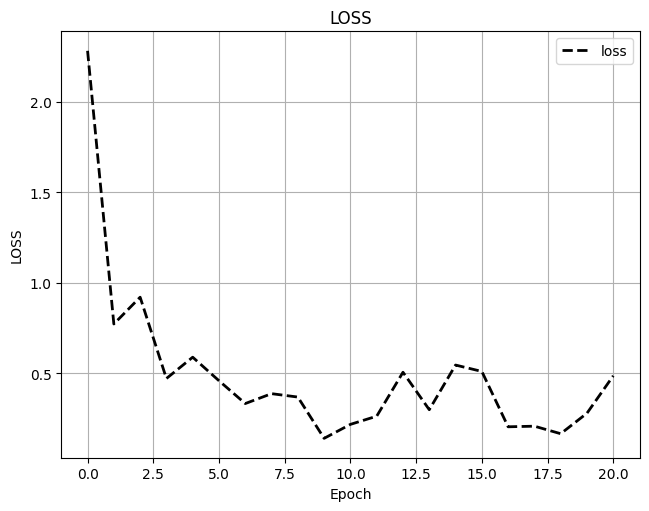

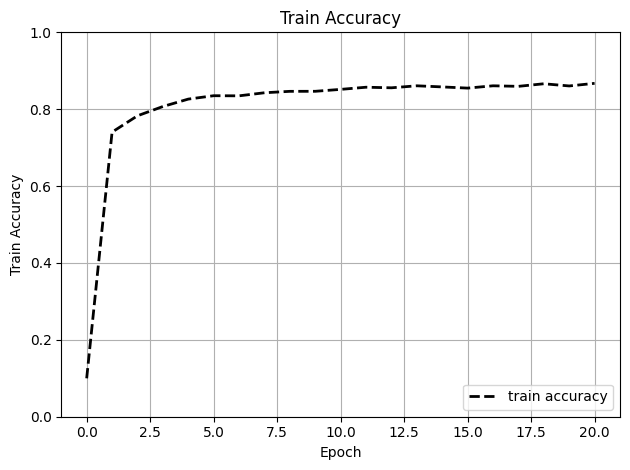

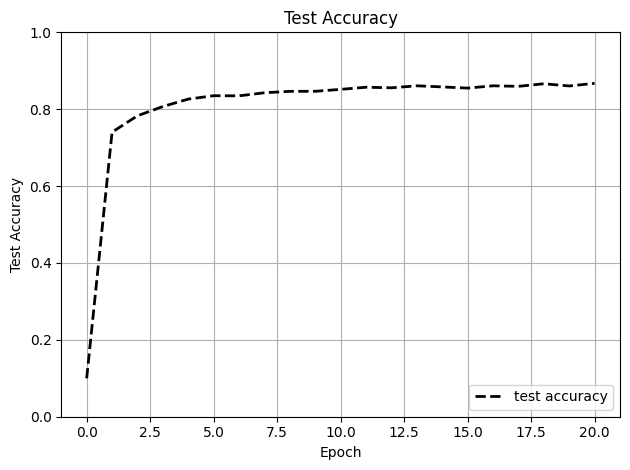

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os



class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(1,4,7,2) # 4 11*11
        self.Relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(4,4,5) # 4 7*7
        self.Relu = torch.nn.ReLU(inplace=True)

        self.features1 = Inception(4,8,8,8,8,8,8) # 32
        self.features2 = Inception(32,8,8,8,8,8,8) # 32
        self.features3 = Inception(32,16,16,16,16,16,16) # 64
        self.features4 = Inception(64,16,16,16,16,16,16) # 64

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(64,10)
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Relu(x)
        x = self.conv2(x)
        x = self.Relu(x)
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = self.features4(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x,(1,1))
        x = torch.flatten(x, start_dim=1)  # 对张量扁平化处理，即将X展开
        x = self.classifier(x)
        return x


class Inception(torch.nn.Module):
    def __init__(self,inchannels,ch1x1,ch3x3r,ch3x3,ch5x5r,ch5x5,pool_proj):
        super(Inception, self).__init__()
        self.batch1 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels,ch1x1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch2 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch3x3r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch3x3r,ch3x3,3,1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch3 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch5x5r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch5x5r,ch5x5,5,1,2),
            torch.nn.ReLU(inplace=True)
        )
        self.batch4 = torch.nn.Sequential(
            torch.nn.MaxPool2d(3, 1, 1),
            torch.nn.Conv2d(inchannels,pool_proj,1),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self,x):
        b1 = self.batch1(x)
        b2 = self.batch2(x)
        b3 = self.batch3(x)
        b4 = self.batch4(x)

        output = [b1,b2,b3,b4] # batch (ch1x1+ch3x3+ch5x5+pool_proj)

        return torch.cat(output, 1)




def main():
    batch_size = 64
    learning_rate = 0.0005
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()


## 使用mini ResNet

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

import torch


class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()  # 1 28*28
        self.b1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 7),  # 64 22*22
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d((3, 3), 1)  # 64 20*20
        )
        self.b2 = torch.nn.Sequential(
            residual(64, 64, False, 1),
            residual(64, 64, False, 1),
            residual(64, 64, False, 1),
            residual(64, 64, False, 1),
        )
        self.b3 = torch.nn.Sequential(
            residual(64, 128, True, 1),
            residual(128, 128, False, 1),
        )
        self.b4 = torch.nn.Sequential(
            residual(128, 256, True, 1),
            residual(256, 256, False, 1),
        )
        self.b5 = torch.nn.Sequential(
            residual(256, 512, True, 1),
            residual(512, 512, False, 1),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.classifier(x)
        return x


class residual(torch.nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super(residual, self).__init__()
        self.Conv1 = torch.nn.Conv2d(input_channels, num_channels, 3, strides, 1)
        self.Conv2 = torch.nn.Conv2d(num_channels, num_channels, 3, 1, 1)
        if use_1x1conv:
            self.Conv3 = torch.nn.Conv2d(input_channels, num_channels, 1, strides)
        else:
            self.Conv3 = None
        self.bn1 = torch.nn.BatchNorm2d(num_channels)
        self.bn2 = torch.nn.BatchNorm2d(num_channels)

    def forward(self, x):
        identity = x
        x = self.Conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.Conv2(x)
        x = self.bn2(x)
        if self.Conv3 is not None:
            identity = self.Conv3(identity)
        x += identity
        x = torch.nn.functional.relu(x)
        return x

def main():
    batch_size = 32
    learning_rate = 0.0001
    num_epoch = 20

    net = LeNet()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # train_loader用于训练
    train_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                          train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
    # test_loader用于测试。
    test_dataset = datasets.FashionMNIST(root='/content/gdrive/MyDrive/Data',
                                         train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)

    criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 随机梯度下降优化器

    '''主训练逻辑'''
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    net.to(device)
    for epoch in range(num_epoch):
        if epoch == 0:
            '''test acc'''
            correct = 0
            total = 0
            with torch.no_grad():
                for test_image, test_label in test_loader:
                    test_image = test_image.float()
                    test_label = test_label.long()

                    Output = net(test_image.to(device))
                    _, predicted = torch.max(Output.data, 1)

                    total += test_label.size(0)
                    correct += (predicted == test_label.to(device)).sum().item()
            test_acc_history.append(correct / total)
            print("test accuracy:{:.2f}%".format(100*correct / total))

        '''train'''
        loss_list = []
        train_list = []
        Loss = 0
        for (i, (train_image, train_labels)) in enumerate(train_loader):

            train_image = train_image.float()
            train_labels = train_labels.long()
            optimizer.zero_grad()

            Outputs = net(train_image.to(device))
            Loss = criterion(Outputs, train_labels.to(device))

            if i == 0 and epoch == 0:
                '''loss'''
                loss_list.append(Loss.item())
                '''train acc'''
                correct = 0
                total = 0
                with torch.no_grad():
                    for train_images, train_labels in train_loader:
                        train_images = train_images.float()
                        train_labels = train_labels.long()

                        Output = net(train_images.to(device))
                        _, predicted = torch.max(Output.data, 1)

                        total += train_labels.size(0)
                        correct += (predicted == train_labels.to(device)).sum().item()

                train_list.append(correct / total)

            Loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:  # 每一轮epoch中，每100个batch通报一次
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                      format(epoch + 1, num_epoch, i + 1, len(train_loader), Loss.item()))

        '''一次train epoch 后'''

        '''loss'''
        loss_list.append(Loss.item())
        '''train acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for train_images, train_labels in train_loader:
                train_images = train_images.float()
                train_labels = train_labels.long()

                Output = net(train_images.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += train_labels.size(0)
                correct += (predicted == train_labels.to(device)).sum().item()

        train_list.append(correct / total)

        loss_history += loss_list
        train_acc_history += train_list

        '''test acc'''
        correct = 0
        total = 0
        with torch.no_grad():
            for test_image, test_label in test_loader:
                test_image = test_image.float()
                test_label = test_label.long()

                Output = net(test_image.to(device))
                _, predicted = torch.max(Output.data, 1)

                total += test_label.size(0)
                correct += (predicted == test_label.to(device)).sum().item()
        test_acc_history.append(correct / total)
        print("test accuracy:{:.2f}%".format(100*correct / total))

    '''测试模型分类的准确率'''
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_label in test_loader:
            test_images = test_images.float()
            test_label = test_label.long()

            outputs = net(test_images.to(device))
            _, predicted = torch.max(outputs.data, 1)

            total += test_label.size(0)
            correct += (predicted == test_label.to(device)).sum().item()

    print('Accuracy of the network on the {} test test_images: {:.2f} %'.format(total, 100 * correct / total))

    '''绘制结果'''
    plt.figure()
    plt.plot(loss_history, color='black', linestyle='--', linewidth=2, label='loss')
    plt.legend(['loss'], loc='upper right')
    plt.grid()
    plt.tight_layout()
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('LOSS')
    plt.savefig('LOSS.png', dpi=300)

    plt.figure()
    plt.plot(train_acc_history, color='black', linestyle='--', linewidth=2, label='train accuracy')
    plt.legend(['train accuracy'], loc='lower right')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Train.png', dpi=300)

    plt.figure()
    plt.plot(test_acc_history, color='black', linestyle='--', linewidth=2, label='test accuracy')
    plt.legend(['test accuracy'], loc='lower right')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('Test.png', dpi=300)

    plt.show()


if __name__ == "__main__":
    main()


using cuda:0 device.
Using 2 dataloader workers every process
test accuracy:10.68%
Epoch [1/20], Step [100/1875], Loss: 0.9143
Epoch [1/20], Step [200/1875], Loss: 1.0137
Epoch [1/20], Step [300/1875], Loss: 0.8136
Epoch [1/20], Step [400/1875], Loss: 0.8187
Epoch [1/20], Step [500/1875], Loss: 0.4321
Epoch [1/20], Step [600/1875], Loss: 0.4323
Epoch [1/20], Step [700/1875], Loss: 0.7782
Epoch [1/20], Step [800/1875], Loss: 0.6891
Epoch [1/20], Step [900/1875], Loss: 0.5866
Epoch [1/20], Step [1000/1875], Loss: 0.7045
Epoch [1/20], Step [1100/1875], Loss: 0.6346
Epoch [1/20], Step [1200/1875], Loss: 0.4956
Epoch [1/20], Step [1300/1875], Loss: 0.4449
Epoch [1/20], Step [1400/1875], Loss: 0.5382
Epoch [1/20], Step [1500/1875], Loss: 0.6688
Epoch [1/20], Step [1600/1875], Loss: 0.4412
Epoch [1/20], Step [1700/1875], Loss: 0.4648
Epoch [1/20], Step [1800/1875], Loss: 0.5022
test accuracy:83.89%
Epoch [2/20], Step [100/1875], Loss: 0.2158
Epoch [2/20], Step [200/1875], Loss: 0.4788
Epoch [